In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2


2023-11-05 10:27:10.167420: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-05 10:27:10.187312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# if using GPU, check this:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))


Num GPUs Available:  1


2023-11-05 10:27:11.020612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 10:27:11.023157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 10:27:11.023225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
import os
from os import path
from PIL import Image


In [4]:
ds_path = path.join(os.getcwd(), "dataset/dataset")
ds_path


'/home/bigai0b/Projects/ThreAIT/dataset/dataset'

In [44]:
path_sci_labels = path.join(os.getcwd(), "dataset/dataset/train/CleanedScissorsAnnotations")
path_kni_labels = path.join(os.getcwd(), "dataset/dataset/train/CleanedKnifeAnnotations")
print(path_kni_labels, path_kni_labels)

/home/bigai0b/Projects/ThreAIT/dataset/dataset/train/CleanedKnifeAnnotations /home/bigai0b/Projects/ThreAIT/dataset/dataset/train/CleanedKnifeAnnotations


In [57]:
!ls /home/bigai0b/Projects/ThreAIT/dataset/dataset/train/CleanedKnifeAnnotations /home/bigai0b/Projects/ThreAIT/dataset/dataset/train/CleanedKnifeAnnotations


/home/bigai0b/Projects/ThreAIT/dataset/dataset/train/CleanedKnifeAnnotations:
N0105205.xml  N0113552.xml  N0118187.xml  N0122995.xml	N0127412.xml
N0105495.xml  N0114194.xml  N0118188.xml  N0123154.xml	N0127708.xml
N0105833.xml  N0114195.xml  N0118231.xml  N0123155.xml	N0133307.xml
N0105870.xml  N0114239.xml  N0118232.xml  N0123199.xml	N0158545.xml
N0106249.xml  N0114290.xml  N0118893.xml  N0123201.xml	N0176089.xml
N0106250.xml  N0114486.xml  N0118894.xml  N0123202.xml	N0177327.xml
N0106640.xml  N0114614.xml  N0118895.xml  N0123203.xml	N0177328.xml
N0106769.xml  N0114795.xml  N0119263.xml  N0123250.xml	N0183666.xml
N0107560.xml  N0114818.xml  N0119264.xml  N0123251.xml	N0187303.xml
N0107561.xml  N0114819.xml  N0119265.xml  N0123443.xml	N0194822.xml
N0107562.xml  N0114820.xml  N0119607.xml  N0123482.xml	N0194823.xml
N0107563.xml  N0114831.xml  N0119819.xml  N0123563.xml	N0195868.xml
N0107978.xml  N0114832.xml  N0119989.xml  N0123656.xml	N0197244.xml
N0107979.xml  N0114834.xml  N0119993.x

In [5]:
# reading the labels for the SIXray dataset
AMOUNT_SAMPLES = 100
labels = pd.read_csv(path.join(ds_path, "ImageSet", str(AMOUNT_SAMPLES), "train.csv"))
labels


,name,Gun,Knife,Wrench,Pliers,Scissors
0,P03198,1,-1,1,-1,-1
1,P02604,1,-1,-1,-1,-1
2,P02457,1,-1,-1,-1,-1
3,P03561,1,1,1,1,-1
4,P00087,1,1,-1,-1,-1
...,...,...,...,...,...,...
749595,N0594736,-1,-1,-1,-1,-1
749596,N0236396,-1,-1,-1,-1,-1
749597,N0483644,-1,-1,-1,-1,-1
749598,N0655534,-1,-1,-1,-1,-1


In [66]:
dims = [1, 384, 384, 3]
training_dims = [1, 256, 256, 3]

def extract_images(path_, dims, debug=False, label_paths = []):
    files = [
        file
        for file in os.listdir(path_)
        if file.endswith(".jpg") or file.endswith(".png")
    ]
    signal_labels = []
    for label_path in label_paths:
        print(label_path)
        signal_label = [
            file[:-4]
            for file in os.listdir(label_path)
            if file.endswith(".xml")
        ]
        print(signal_label)
        signal_labels += signal_label
    #signal_labels = np.array(signal_labels).flatten()
    print(signal_labels)
    images = []
    index = 0
    if(debug): print("total number of images: ", len(files))
    for file in files:
        index += 1
        if index > 20000:
            continue
        #print(np.shape(np.sum(labels[labels["name"] == file[:-4]][-4:])))
        #print(np.sum(labels[labels["name"] == file[:-4]][:,-4:]))
        #print("sample name: ", file[:-4])
        #if(np.sum(labels["name"] == file[:-4]) == 0): 
        #    continue
        #print("labels of the sample: ", labels[labels["name"] == file[:-4]])
        #print("label sum: ", labels[labels["name"] == file[:-4]].iloc[:,-4:].to_numpy())
        #if(np.sum(labels[labels["name"] == file[:-4]].iloc[:,-4:].to_numpy()) != -4):
        #    print(labels[labels["name"] == file[:-4]])
        if(file[:-4] in signal_labels):
            print("signal: ", file[:-4] )
            continue
        try:
            img = Image.open(os.path.join(path_, file)).convert("RGB").resize(dims[1:3])
            img = np.asarray(img)
            img = img.reshape(dims)
            images.append(img)
        except:
            print("Could not open the file:", file)
            break

    images = np.concatenate(images, axis=0)
    return images


In [67]:
images = extract_images(path_=path.join(ds_path, "JPEGImage"), dims=dims, debug = False, label_paths=[path_kni_labels, path_sci_labels])


/home/bigai0b/Projects/ThreAIT/dataset/dataset/train/CleanedKnifeAnnotations
['N0124533', 'N0116927', 'N0117608', 'N0109395', 'N0109469', 'N0365211', 'N0114195', 'N0114970', 'N0123988', 'N0107979', 'N0115174', 'N0123203', 'N0117969', 'N0158545', 'N0119607', 'N0106640', 'N0121700', 'N0126068', 'N0113070', 'N0124315', 'N0176089', 'N0118893', 'N0105870', 'N0115885', 'N0114818', 'N0116190', 'N0336453', 'N0125541', 'N0122747', 'N0121047', 'N0110577', 'N0117708', 'N0123202', 'N0124951', 'N0122323', 'N0220818', 'N0125540', 'N0365013', 'N0177327', 'N0117935', 'N0106769', 'N0125177', 'N0122427', 'N0115802', 'N0122137', 'N0124384', 'N0114290', 'N0122324', 'N0110848', 'N0108011', 'N0112926', 'N0105205', 'N0122646', 'N0112767', 'N0367544', 'N0194823', 'N0123443', 'N0126866', 'N0118187', 'N0183666', 'N0123660', 'N0201651', 'N0123656', 'N0107560', 'N0206689', 'N0126243', 'N0122231', 'N0122867', 'N0113552', 'N0108618', 'N0317237', 'N0112828', 'N0119263', 'N0126867', 'N0117961', 'N0112609', 'N0133307'

In [53]:
class ThreAITGenerator(keras.utils.Sequence):
    def __init__(self, data, labels, batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        self.random = np.random.RandomState(seed)
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        batch_data = [self.data[i] for i in indices]
        batch_labels = [self.labels[i] for i in indices]
        
        return np.array(batch_data), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            self.random.shuffle(self.indices)

In [9]:
img_processed = np.array(images[0])

red_hist = plt.hist(test[:,:,0].flatten(),range=[155,255],bins=100,label='red',color='red')
blue_hist = plt.hist(test[:,:,1].flatten(),range=[155,255],bins=100,label='blue',color='blue')
green_hist = plt.hist(test[:,:,2].flatten(),range=[155,255],bins=100,label='green',color='green')


plt.imshow(test, cmap="gray")

In [10]:
def find_filled_contour(image):
    if np.max(image) < 1.01:
        print("The image format needs to be 0-255 uint8")
        return 0
    # Invert the image
    image = (255-image).astype("uint8") 
    # Make sure there is a ground 0 point
    image = image - np.min(image)
    # Threshold and find contours
    if(np.shape(image)[2] == 3):
        image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    thresholded = cv2.adaptiveThreshold(image.astype(np.uint8), 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, -25) # Fine tuned parameters 9 and -25
    contours, _ = cv2.findContours(thresholded.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0, 0, image.shape[1], image.shape[0]

    # Find the bounding rectangle
    x_min = y_min = np.inf
    x_max = y_max = 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)
    if x_min == np.inf or y_min == np.inf or x_max == -np.inf or y_max == -np.inf:
        return 0, 0, image.shape[1], image.shape[0]

    # Return the bounding rectangle coordinates 
    return int(x_min), int(y_min), int(x_max), int(y_max)


In [12]:
sample_contours = [find_filled_contour(image) for image in images]
training_sample = np.array([cv2.resize(image[result_box[1]:result_box[3], result_box[0]:result_box[2]], [256,256]) 
                   for result_box, image in zip(sample_contours, images) ])

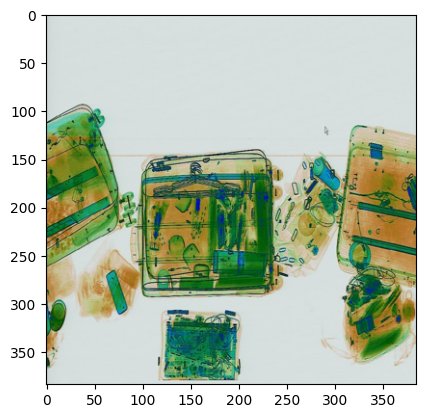

In [13]:
plt.imshow(images[99])

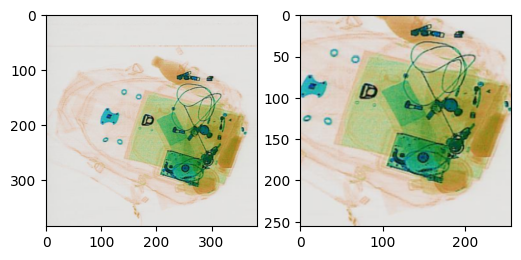

In [14]:
index = 2000
fig, ax = plt.subplots(1,2,figsize=[6,12])
ax[0].imshow(images[index])
ax[1].imshow(training_sample[index])

### print(images[98][:,0])


In [28]:
from libthreait.ThreAIT import ThreAIT
from libthreait.encoder import make_model_encoder
from libthreait.decoder import make_model_decoder
%reload_ext autoreload
%autoreload 2

In [29]:
input_shape = training_dims[1:4]
encoded_shape = 2048
output_shape = training_dims[1:4]
encoder_network = make_model_encoder(input_shape, encoded_shape)
decoder_network = make_model_decoder(encoded_shape, output_shape)
anomaly_detector = ThreAIT(encoder=encoder_network, decoder=decoder_network)

In [30]:
encoder_network.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 efficientnetv2-m (Function  (None, 8, 8, 1280)           5315038   ['input_7[0][0]']             
 al)                                                      8                                       
                                                                                                  
 conv2d_4 (Conv2D)           (None, 8, 8, 256)            2949376   ['efficientnetv2-m[0][0]']    
                                                                                                  
 conv2d_5 (Conv2D)           (None, 8, 8, 128)            295040    ['conv2d_4[0][0]']      

In [31]:
decoder_network.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense_8 (Dense)             (None, 131072)            268566528 
                                                                 
 reshape_2 (Reshape)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 64, 64, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 128, 128, 32)      18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_10 (Conv2  (None, 256, 256, 16)      4624

In [32]:
batch_size = 64  # also a hyperparameter
annealer = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-6, decay_steps=200
)

savebest = tf.keras.callbacks.ModelCheckpoint(
    filepath="anom_thisisthebest.h5",
    save_weights_only=True,
    monitor="val_reconstruction_loss",
    save_best_only=True,
    mode="auto",
)

stopearly = tf.keras.callbacks.EarlyStopping(
    monitor="val_reconstruction_loss",
    patience=20,
    mode="auto",
    restore_best_weights=True,
)

callbacks = [savebest, stopearly]
anomaly_detector.compile(
    ae_optimizer=keras.optimizers.Adam(learning_rate=annealer),
    loss_fn=tf.keras.losses.MeanSquaredError(),
)

In [33]:
print(np.min(images))

0


In [34]:
""" if (images.shape[0]%(batch_size*4)) != 0:
    images = images[:-(images.shape[0]%(batch_size*4))] """
print(images.shape)
epochs = 200
img_processed = anomaly_detector.fit(
    training_sample,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=1 / 9,
)


(20000, 384, 384, 3)
Epoch 1/200
278/278 [==============================] - 40s 123ms/step - loss: 8960.6442 - reconstruction_loss: 2927.9486 - kl_loss: 6032.6956 - val_loss: 2498.9685 - val_reconstruction_loss: 2496.6987 - val_kl_loss: 2.2698
Epoch 2/200
278/278 [==============================] - 32s 117ms/step - loss: 2088.2687 - reconstruction_loss: 2083.9577 - kl_loss: 4.3110 - val_loss: 2162.2219 - val_reconstruction_loss: 2158.8345 - val_kl_loss: 3.3875
Epoch 3/200
278/278 [==============================] - 33s 117ms/step - loss: 1840.4570 - reconstruction_loss: 1835.2966 - kl_loss: 5.1604 - val_loss: 1879.3466 - val_reconstruction_loss: 1875.4172 - val_kl_loss: 3.9294
Epoch 4/200
278/278 [==============================] - 33s 117ms/step - loss: 1707.0543 - reconstruction_loss: 1692.3641 - kl_loss: 14.6902 - val_loss: 1795.9512 - val_reconstruction_loss: 1791.1434 - val_kl_loss: 4.8078
Epoch 5/200
278/278 [==============================] - 33s 117ms/step - loss: 1598.7086 - recon

KeyboardInterrupt: 

In [ ]:
encod_mean, encod_log, encoded = anomaly_detector.encoder.predict(
    training_sample[:1000], batch_size=64
)


In [ ]:
output = anomaly_detector.decoder.predict(encoded, batch_size=64)


In [ ]:
output = output.astype("uint8")


In [ ]:
plt.imshow(images[5])


In [ ]:
np.min(output[5])


In [ ]:
plt.imshow(images[236])


In [ ]:
plt.imshow(output[236])
